### Importing Libraries

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras_vggface.vggface import VGGFace

Using TensorFlow backend.


## Model Training

There will be 4 seperate models trained to predict age, gender, ethnicity and emotion.

Training Approach : Transfer learning on a pre-trained resnet50 convolutional neural network.

#### 1. Gender Model

In [2]:
X=[]
Z=[]
IMG_SIZE=150
GENDER_MALE_DIR='dataset/gender/G_Male/'
GENDER_FEMALE_DIR='dataset/gender/G_Female/'
#weights_path='support_files/vgg-face-keras.h5'
#weights_path='support_files/vggface2_Keras.h5'

In [3]:
def assign_label(img,label):
    return label

In [4]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [5]:
make_train_data('Male',GENDER_MALE_DIR)
make_train_data('Female',GENDER_FEMALE_DIR)

100%|██████████| 112/112 [00:00<00:00, 1672.72it/s]


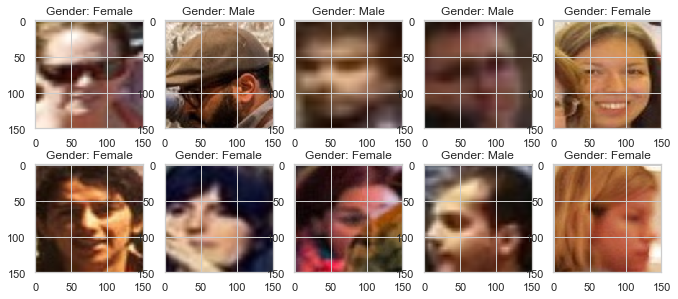

In [7]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:,:,::-1])
        ax[i,j].set_title('Gender: '+Z[l])
        #ax[i,j].set_xticklabels([])
        #ax[i,j].set_yticklabels([])
        ax[i,j].set_aspect('equal')

In [8]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [9]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [10]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [11]:
base_model=ResNet50(include_top=False, weights=None,input_shape=(150,150,3), pooling='avg')

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
weights_path='support_files/vggface2_Keras.h5'
base_model.load_weights(weights_path, by_name='True')

In [13]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 19, 19, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 19, 19, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 19, 19, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 10, 10, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 5, 5, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 5, 5, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 5, 5, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 5, 5, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 5, 5, 512)    0           bn5b_branch2b[0][0]              
__________

In [14]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 24,113,541
Trainable params: 24,060,421
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [17]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

C:\Users\Atulya\Anaconda3\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [18]:
base_model.trainable=False # setting the VGG model to be untrainable.

In [19]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])


In [20]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1/1 [==============================] - 49s 49s/step - loss: 2.7060 - acc: 0.4531 - val_loss: 6.6905 - val_acc: 0.5849
Epoch 2/50
1/1 [==============================] - 20s 20s/step - loss: 1.5562 - acc: 0.5333 - val_loss: 6.6905 - val_acc: 0.5849
Epoch 3/50
1/1 [==============================] - 43s 43s/step - loss: 0.9775 - acc: 0.4844 - val_loss: 9.4276 - val_acc: 0.4151
Epoch 4/50
1/1 [==============================] - 20s 20s/step - loss: 1.0011 - acc: 0.4667 - val_loss: 9.4276 - val_acc: 0.4151
Epoch 5/50
1/1 [==============================] - 50s 50s/step - loss: 1.0987 - acc: 0.5078 - val_loss: 9.4276 - val_acc: 0.4151
Epoch 6/50
1/1 [==============================] - 20s 20s/step - loss: 1.2656 - acc: 0.4000 - val_loss: 9.4276 - val_acc: 0.4151
Epoch 7/50
1/1 [==============================] - 44s 44s/step - loss: 0.9181 - acc: 0.4922 - val_loss: 9.4276 - val_acc: 0.4151
Epoch 8/50
1/1 [==============================] -